In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
dataset_path = "ISIC_2019_Training_Input"

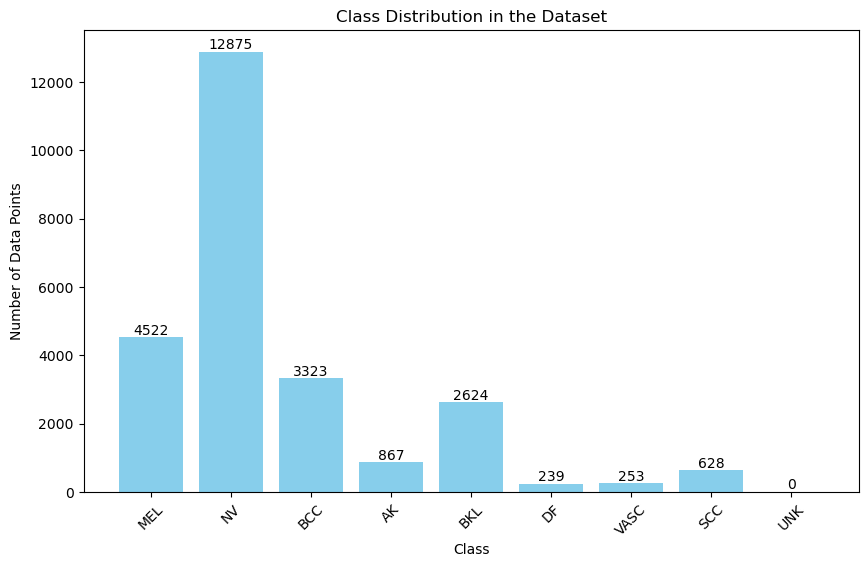

In [19]:
# Load the CSV file
csv_path = "ISIC_2019_Training_GroundTruth.csv"
df = pd.read_csv(csv_path)

# Sum the counts of each class
class_counts = df.iloc[:, 1:].sum()

# Plot the class distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue')

# Add numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=45)
plt.show()

In [20]:
def load_and_relabel_metadata(csv_path, output_path=None):
    # Load the original metadata
    df = pd.read_csv(csv_path)
    # Define melanoma and non-melanoma categories
    melanoma = ['MEL']
    non_melanoma = ['NV', 'AK', 'BKL', 'DF', 'VASC', 'BCC', 'SCC']
    # Drop the 'UNK' column (if present)
    if 'UNK' in df.columns:
        df = df.drop(['UNK'], axis=1)
    # Create a new column 'class' where 1 represents melanoma and -1 represents non-melanoma
    df['class'] = 2 * (df[melanoma].sum(axis=1) > 0).astype(int) - 1
    # Drop the original class columns
    df = df.drop(melanoma + non_melanoma, axis=1)
    # Save the relabeled metadata to a new CSV file
    if output_path is None:
        output_path = "relabeled_metadata_svm.csv"
    
    df.to_csv(output_path, index=False)
    print(f"Relabeled metadata saved to: {output_path}")
    # Print statistics about the dataset
    total_entries = len(df)
    print(f"\nTotal entries in relabeled file: {total_entries}")
    return df

def plot_class_distribution(relabeled_metadata):
    # Get class counts
    class_counts = relabeled_metadata['class'].value_counts().sort_index()
    # Define custom colors for the bars
    colors = ['#ff7f0e', '#1f77b4']  # Orange for non-melanoma (-1), blue for melanoma (1)
    # Create a bar plot with colors and display actual counts
    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Non-Melanoma (-1)', 'Melanoma (1)'], class_counts.values, color=colors)
    # Add text labels above the bars showing the count
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=12)
    # Add labels and title
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution for SVM')
    # Show the plot
    plt.show()

Relabeled metadata saved to: relabeled_metadata_svm.csv

Total entries in relabeled file: 25331


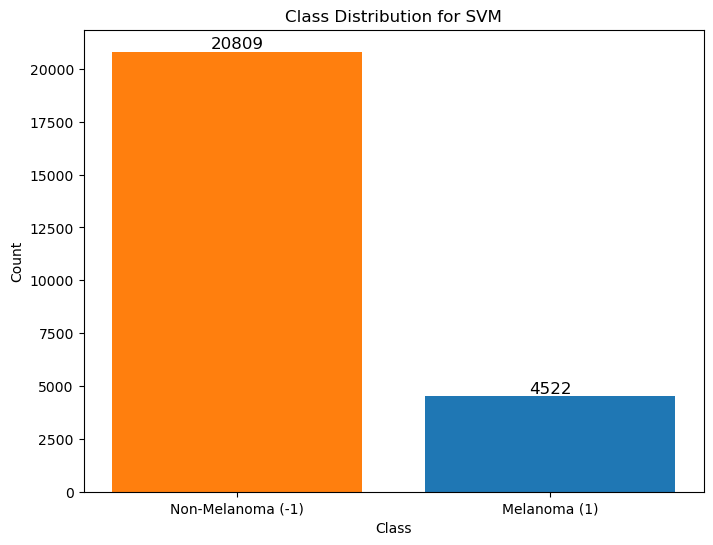

In [21]:
# Load and relabel the metadata
relabeled_df = load_and_relabel_metadata(csv_path)

# Plot the class distribution
plot_class_distribution(relabeled_df)

In [22]:
# Print the first few rows to verify the relabeling
print(relabeled_df.head())

# Print column names to verify
print("\nColumns in relabeled metadata:")
print(sum(relabeled_df['class'] == 0))

          image  class
0  ISIC_0000000     -1
1  ISIC_0000001     -1
2  ISIC_0000002      1
3  ISIC_0000003     -1
4  ISIC_0000004      1

Columns in relabeled metadata:
0


In [23]:
# Split your dataset into train and test sets
train_metadata_df, test_metadata_df = train_test_split(relabeled_df, test_size=0.2, stratify=relabeled_df['class'], random_state=42)

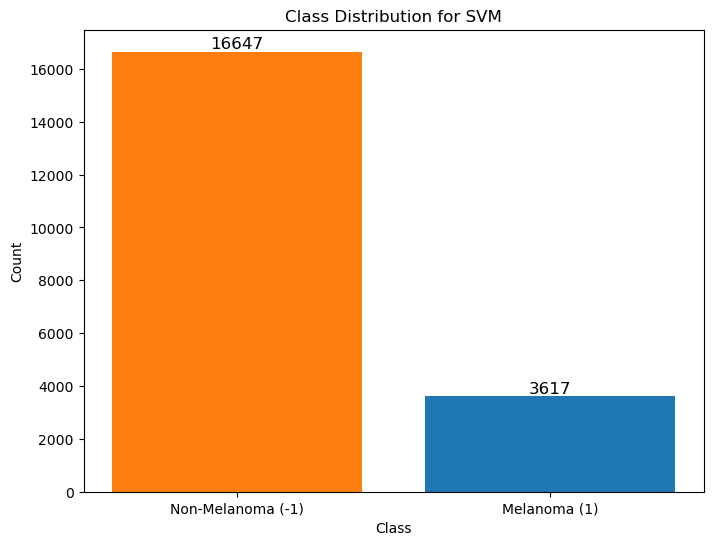

In [24]:
# Plot the class distribution
plot_class_distribution(train_metadata_df)

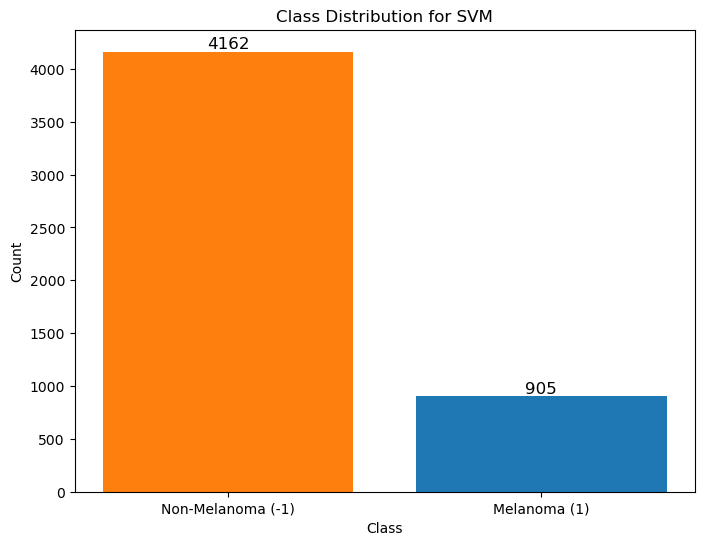

In [25]:
# Plot the class distribution
plot_class_distribution(test_metadata_df)

In [26]:
def apply_augmentations(image):
    """Apply data augmentation to an input image before any other preprocessing."""
    augmented_images = []
    augmented_names = []

    # Base image
    augmented_images.append(image)
    augmented_names.append('original')

    # 90 degree clockwise rotation
    rotated_90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    augmented_images.append(rotated_90)
    augmented_names.append('rotated_90')

    # 90 degree counterclockwise rotation
    rotated_270 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    augmented_images.append(rotated_270)
    augmented_names.append('rotated_270')

    # Vertical flip
    flipped = cv2.flip(image, 0)
    augmented_images.append(flipped)
    augmented_names.append('vertical_flip')

    # Mirroring (horizontal flip)
    mirrored = cv2.flip(image, 1)
    augmented_images.append(mirrored)
    augmented_names.append('mirrored')

    return augmented_images, augmented_names

def extract_roi(img_rgb):
    """Extract ROI from an RGB image."""
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    
    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [largest_contour], 0, 255, -1)
    
    roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
    x, y, w, h = cv2.boundingRect(largest_contour)
    roi_cropped = roi[y:y+h, x:x+w]
    
    return roi_cropped

def resize_and_pad(image, target_size=224):
    """Resize and pad image to target size."""
    old_size = image.shape[:2]
    ratio = float(target_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    
    resized = cv2.resize(image, (new_size[1], new_size[0]))
    
    delta_w = target_size - new_size[1]
    delta_h = target_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded

def process_single_image(image_path, apply_augmentation=True):
    """Process a single image with optional augmentation."""
    # Load and convert image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    processed_images = []
    image_names = []
    
    if apply_augmentation:
        # Apply augmentations first
        augmented_images, aug_names = apply_augmentations(img_rgb)
    else:
        augmented_images = [img_rgb]
        aug_names = ['original']
    
    # Process each augmented version
    for aug_img, aug_name in zip(augmented_images, aug_names):
        # Extract ROI
        roi = extract_roi(aug_img)
        
        # Resize and pad
        processed = resize_and_pad(roi)
        
        # Preprocess for model
        processed = preprocess_input(processed.astype(np.float32))
        
        processed_images.append(processed)
        image_names.append(aug_name)
    
    return processed_images, image_names

def process_dataset_with_metadata(metadata_df, dataset_path, output_dir, apply_augmentation=True, is_training=True):
    """Process entire dataset with metadata.
    
    Processes all images in the dataset, ensuring:
    1. All non-melanoma images are saved
    2. All original melanoma images are processed first
    3. Augmentations are only applied to melanoma images if needed to balance the dataset
    """
    os.makedirs(output_dir, exist_ok=True)
    
    all_class_encodings = []
    all_image_names = []
    
    # Calculate dataset statistics
    non_melanoma_count = sum(metadata_df['class'] == -1)
    melanoma_count = sum(metadata_df['class'] == 1)
    
    # Calculate how many additional melanoma samples we need
    if is_training and apply_augmentation:
        target_melanoma_count = non_melanoma_count
        melanoma_images_needed = target_melanoma_count - melanoma_count
    else:
        melanoma_images_needed = 0
    
    total_images = len(metadata_df)  # Changed from metadata_df['image']
    
    # First pass: Process all original images (both melanoma and non-melanoma)
    print("Processing all original images...")
    for index, row in metadata_df.iterrows():  # Changed to iterate over rows
        image_name = row['image']
        class_encoding = row['class']  # Get class directly from row
        
        print(f"Processing original image {index + 1}/{total_images}: {image_name}")
        
        image_path = os.path.join(dataset_path, image_name + '.jpg')
        if not os.path.exists(image_path):
            print(f"Error: Image file not found at {image_path}")
            continue
        
        # Process original image without augmentation
        processed_images, image_names = process_single_image(image_path, apply_augmentation=False)
        
        # Save processed original image
        base_name = os.path.splitext(image_name)[0]
        for proc_img, img_name in zip(processed_images, image_names):
            save_path = os.path.join(output_dir, f"{base_name}_{img_name}.npy")
            np.save(save_path, proc_img)
            all_image_names.append(f"{base_name}_{img_name}.npy")
            all_class_encodings.append(class_encoding)  # Use class from metadata
    
    # Second pass: Apply augmentations to melanoma images if needed
    if is_training and apply_augmentation and melanoma_images_needed > 0:
        print("\nApplying augmentations to melanoma images...")
        melanoma_images = metadata_df[metadata_df['class'] == 1]  # Changed to get full rows
        
        additional_melanoma_count = 0
        for _, row in melanoma_images.iterrows():  # Changed to iterate over rows
            if additional_melanoma_count >= melanoma_images_needed:
                break
                
            image_name = row['image']
            image_path = os.path.join(dataset_path, image_name + '.jpg')
            if not os.path.exists(image_path):
                continue
            
            # Process image with augmentation
            processed_images, image_names = process_single_image(image_path, apply_augmentation=True)
            
            # Save augmented versions (skip the first one as it's the original)
            base_name = os.path.splitext(image_name)[0]
            for proc_img, img_name in zip(processed_images[1:], image_names[1:]):  # Skip original
                if additional_melanoma_count >= melanoma_images_needed:
                    break
                    
                save_path = os.path.join(output_dir, f"{base_name}_{img_name}.npy")
                np.save(save_path, proc_img)
                all_image_names.append(f"{base_name}_{img_name}.npy")
                all_class_encodings.append(1)  # class encoding for melanoma
                additional_melanoma_count += 1
    
    print("\nProcessing complete.")
    if is_training and apply_augmentation:
        final_melanoma_count = melanoma_count + additional_melanoma_count
        print(f"Original melanoma images: {melanoma_count}")
        print(f"Additional augmented melanoma images: {additional_melanoma_count}")
        print(f"Final melanoma count: {final_melanoma_count}")
        print(f"Non-melanoma count: {non_melanoma_count}")
        print(f"Total images processed: {len(all_class_encodings)}")
        print(f"Difference: {final_melanoma_count - non_melanoma_count}")

    return all_class_encodings, all_image_names

In [27]:
train_output_dir = 'preprocessed/train'
test_output_dir = 'preprocessed/test'

In [28]:
# Process training set with augmentation for balance
train_encodings, train_images = process_dataset_with_metadata(
    metadata_df=train_metadata_df,
    dataset_path='ISIC_2019_Training_Input',
    output_dir=train_output_dir,
    apply_augmentation=True,
    is_training=True  # This ensures augmentation is applied only to training set
)

# Process test/validation set without augmentation
test_encodings, test_images = process_dataset_with_metadata(
    metadata_df=test_metadata_df,
    dataset_path='ISIC_2019_Training_Input',
    output_dir=test_output_dir,
    apply_augmentation=False,  # No augmentation for test set
    is_training=False  # Indicates this is test/validation data
)

Processing all original images...
Processing original image 23105/20264: ISIC_0069696
Processing original image 14987/20264: ISIC_0056809
Processing original image 2177/20264: ISIC_0014278_downsampled
Processing original image 1168/20264: ISIC_0011228
Processing original image 25031/20264: ISIC_0072796
Processing original image 684/20264: ISIC_0009873
Processing original image 2826/20264: ISIC_0015985_downsampled
Processing original image 3854/20264: ISIC_0025256
Processing original image 14324/20264: ISIC_0055735
Processing original image 10314/20264: ISIC_0031716
Processing original image 8572/20264: ISIC_0029974
Processing original image 5068/20264: ISIC_0026470
Processing original image 4473/20264: ISIC_0025875
Processing original image 7716/20264: ISIC_0029118
Processing original image 19214/20264: ISIC_0063571
Processing original image 22806/20264: ISIC_0069249
Processing original image 20820/20264: ISIC_0066131
Processing original image 3773/20264: ISIC_0025175
Processing origin

In [29]:
def save_to_csv(class_encodings, image_names, output_dir, prefix):
    """Save image names and class encodings to CSV file with validation."""
    # Create the directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create a DataFrame with image names and their corresponding class encodings
    df = pd.DataFrame({
        'image_name': image_names,
        'class': class_encodings
    })
    
    # Validate the data
    melanoma_count = sum(df['class'] == 1)
    non_melanoma_count = sum(df['class'] == -1)
    total_count = len(df)
    
    print("\nDataset Statistics:")
    print(f"Total images: {total_count}")
    print(f"Melanoma images: {melanoma_count}")
    print(f"Non-melanoma images: {non_melanoma_count}")
    print(f"Class distribution: {df['class'].value_counts()}")
    
    # Save the DataFrame to a CSV file
    csv_path = os.path.join(output_dir, f"{prefix}_ground_truth.csv")
    df.to_csv(csv_path, index=False)
    print(f"\nGround truth saved to: {csv_path}")


In [30]:
train_output_dir = "preprocessed/train/ground_truth"
test_output_dir = "preprocessed/test/ground_truth"

In [31]:
save_to_csv(
    class_encodings=train_encodings,
    image_names=train_images,
    output_dir=train_output_dir,
    prefix="train"
)

save_to_csv(
    class_encodings=test_encodings,
    image_names=test_images,
    output_dir=test_output_dir,
    prefix="test"
)


Dataset Statistics:
Total images: 33294
Melanoma images: 16647
Non-melanoma images: 16647
Class distribution: class
-1    16647
 1    16647
Name: count, dtype: int64

Ground truth saved to: preprocessed/train/ground_truth\train_ground_truth.csv

Dataset Statistics:
Total images: 5067
Melanoma images: 905
Non-melanoma images: 4162
Class distribution: class
-1    4162
 1     905
Name: count, dtype: int64

Ground truth saved to: preprocessed/test/ground_truth\test_ground_truth.csv


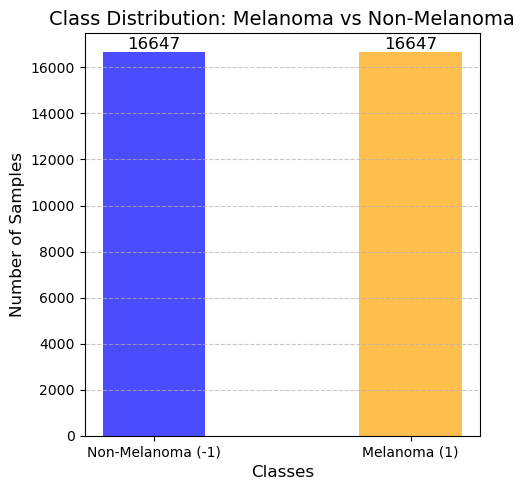

In [32]:
# Load the dataset
data = pd.read_csv('preprocessed/train/ground_truth/train_ground_truth.csv')

# Assuming your dataframe has a column named 'class' for the class labels
# Count the occurrences of each class
class_counts = data['class'].value_counts()

# Create a histogram
plt.figure(figsize=(5, 5))
bars = plt.bar(class_counts.index, class_counts.values, color=['blue', 'orange'], alpha=0.7)

# Set the title and labels
plt.title('Class Distribution: Melanoma vs Non-Melanoma', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(ticks=[-1, 1], labels=['Non-Melanoma (-1)', 'Melanoma (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add exact counts on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Feature Extraction with MobileNetV2

In [33]:
def setup_model():
    input_shape = (224, 224, 3)
    base_model = MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False, pooling='avg')
    base_model.trainable = False  # Freeze the base model
    return base_model

def get_features(image_path, features_dir, base_model):
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    features_path = os.path.join(features_dir, base_filename + '.npy')
    
    if os.path.exists(features_path):
        features = np.load(features_path)
    else:
        img_array = np.load(image_path)
        
        if img_array.shape != (224, 224, 3):
            raise ValueError(f"Loaded image shape {img_array.shape} does not match expected input shape (224, 224, 3)")

        img_array = np.expand_dims(img_array, axis=0)
        features = base_model.predict(img_array).flatten()
        np.save(features_path, features)
    
    return features

def extract_features(df, preprocessed_dir, features_dir, base_model):
    os.makedirs(features_dir, exist_ok=True)

    features = []
    for _, row in df.iterrows():
        image_path = os.path.join(preprocessed_dir, row['image_name'])
        features.append(get_features(image_path, features_dir, base_model))

    return np.array(features)

def process_dataset(ground_truth_path, preprocessed_dir, features_dir, base_model):
    df = pd.read_csv(ground_truth_path)
    features = extract_features(df, preprocessed_dir, features_dir, base_model)
    return features, df['class'].values

# Main execution
if __name__ == "__main__":
    base_model = setup_model()

    # Paths for training set
    train_ground_truth_path = os.path.join(train_output_dir, "train_ground_truth.csv")
    train_features_dir = 'preprocessed/train/extracted_features_gpu'  # Updated to save directly in preprocessed/train
    preprocessed_train_dir = 'preprocessed/train'

    # Process training set
    X_train, y_train = process_dataset(train_ground_truth_path, preprocessed_train_dir, train_features_dir, base_model)
    print(f"Training features shape: {X_train.shape}")
    print(f"Training labels shape: {y_train.shape}")

    # Paths for test set
    test_ground_truth_path = os.path.join(test_output_dir, "test_ground_truth.csv")
    test_features_dir = 'preprocessed/test/extracted_features_gpu'  # Updated to save directly in preprocessed/test
    preprocessed_test_dir = 'preprocessed/test'

    # Process test set
    X_test, y_test = process_dataset(test_ground_truth_path, preprocessed_test_dir, test_features_dir, base_model)
    print(f"Test features shape: {X_test.shape}")
    print(f"Test labels shape: {y_test.shape}")


1/1 [==============================] - 0s 19ms/step
Training features shape: (33294, 1280)
Training labels shape: (33294,)
1/1 [==============================] - 0s 22ms/step
Test features shape: (5067, 1280)
Test labels shape: (5067,)


# Support Vector Machine Linear

In [34]:
from sklearn.metrics import confusion_matrix, recall_score
from cvxopt import matrix, spmatrix, solvers

In [38]:
class SVM:
    def __init__(self, C=1.0):
        self.C = C

    def fit(self, X, y):
        n_samples, n_features = X.shape

        K = np.dot(X, X.T)

        P = matrix(np.outer(y, y) * K)
        q = matrix(-1 * np.ones(n_samples))
        A = matrix(y, (1, n_samples), 'd')
        b = matrix(0.0)

        G = spmatrix([], [], [], (n_samples * 2, n_samples))
        G[:n_samples, :n_samples] = spmatrix(-1.0, range(n_samples), range(n_samples))  # -alpha <= 0 (for soft margin)
        G[n_samples:, :n_samples] = spmatrix(1.0, range(n_samples), range(n_samples))   # alpha <= C

        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

        # Solve QP problem
        solution = solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non-zero Lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
        self.b /= len(self.a)

        # Weight vector
        self.w = np.zeros(n_features)
        for n in range(len(self.a)):
            self.w += self.a[n] * self.sv_y[n] * self.sv[n]

    def project(self, X):
        return np.dot(X, self.w) + self.b

    def predict(self, X):
        return np.sign(self.project(X))


In [ ]:
from joblib import dump, load
import gc

# Test with multiple values of C
C_values = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 10]

# Ensure the models directory exists
os.makedirs('models_linear', exist_ok=True)

for C in C_values:
    print(f"Processing model with C = {C}")
    
    # Define the model file path
    model_path = os.path.join('models_linear', f'svm_model_C_{C}.joblib')

    # Check if the model already exists
    if os.path.exists(model_path):
        print(f"Model already exists for C = {C}. Skipping training.")
    else:
        print(f"Training model with C = {C}")
        model = SVM(C=C)
        model.fit(X_train, y_train)

        # Save the model
        dump(model, model_path, compress=3)
        print(f"Model trained and saved to: {model_path}")

        # Clear the model from memory
        del model
        gc.collect()  # Force garbage collection

print("All models processed.")

Processing model with C = 0.2
Model already exists for C = 0.2. Skipping training.
Processing model with C = 0.3
Model already exists for C = 0.3. Skipping training.
Processing model with C = 0.4
Model already exists for C = 0.4. Skipping training.
All models processed.


In [39]:
# Testing phase
print("\nTesting models:")
for C in C_values:
    print(f"\nTesting model with C = {C}")
    
    model_path = os.path.join('models_linear', f'svm_model_C_{C}.joblib')
    
    # Load the model
    model = load(model_path)
    
    # Perform predictions on the test set
    print('X_test.shape:', X_test.shape)
    print('y_test.shape:', y_test.shape)
    y_proj = model.project(X_test)
    y_pred = model.predict(X_test)
    
    # Display first few results
    print('Projected:', y_proj[:5])
    print('Predicted:', y_pred[:5])
    
    # Confusion matrix and recall
    cm = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print('Confusion Matrix:\n', cm)
    print(f'Recall for C = {C}: {recall:.4f}')

    # Clear the model from memory
    del model
    gc.collect()

print("\nTesting completed.")


Testing models:

Testing model with C = 0.2
X_test.shape: (5067, 1280)
y_test.shape: (5067,)
Projected: [-0.27643086  0.34721812 -0.92652649 -2.38582313 -3.06615463]
Predicted: [-1.  1. -1. -1. -1.]
Confusion Matrix:
 [[3157 1005]
 [ 258  647]]
Recall for C = 0.2: 0.7149

Testing model with C = 0.3
X_test.shape: (5067, 1280)
y_test.shape: (5067,)
Projected: [-0.24720034  0.31968704 -0.95827075 -2.38619655 -3.05178076]
Predicted: [-1.  1. -1. -1. -1.]
Confusion Matrix:
 [[3154 1008]
 [ 259  646]]
Recall for C = 0.3: 0.7138

Testing model with C = 0.4
X_test.shape: (5067, 1280)
y_test.shape: (5067,)
Projected: [-0.2830311   0.33897585 -0.99108544 -2.44441461 -3.07783513]
Predicted: [-1.  1. -1. -1. -1.]
Confusion Matrix:
 [[3153 1009]
 [ 260  645]]
Recall for C = 0.4: 0.7127

Testing completed.


# Support Vector Machine RBF

In [8]:
import numpy as np
from cvxopt import matrix, solvers
from cvxopt import spmatrix
from scipy.spatial.distance import pdist, squareform
import numba

class SVM_RBF:
    def __init__(self, C=1.0, gamma=0.1, chunk_size=1000, tolerance=1e-5):
        self.C = C
        self.gamma = gamma
        self.chunk_size = chunk_size
        self.tolerance = tolerance

    @staticmethod
    @numba.jit(nopython=True, parallel=True)
    def _rbf_kernel_numba(X1, X2, gamma):
        """
        Accelerated RBF kernel computation using Numba
        """
        n_samples1, n_features = X1.shape
        n_samples2 = X2.shape[0]
        K = np.zeros((n_samples1, n_samples2))
        
        for i in numba.prange(n_samples1):
            for j in range(n_samples2):
                dist = 0.0
                for k in range(n_features):
                    diff = X1[i, k] - X2[j, k]
                    dist += diff * diff
                K[i, j] = np.exp(-gamma * dist)
        return K

    def rbf_kernel_chunk(self, X1, X2, start, end):
        """
        Optimized RBF kernel computation using broadcasting and Numba
        """
        return self._rbf_kernel_numba(X1[start:end], X2, self.gamma)

    def fit(self, X, y):
        n_samples = X.shape[0]
        
        # Pre-compute kernel matrix more efficiently using chunks
        P = np.zeros((n_samples, n_samples))
        for i in range(0, n_samples, self.chunk_size):
            end_i = min(i + self.chunk_size, n_samples)
            K_chunk = self.rbf_kernel_chunk(X, X, i, end_i)
            P[i:end_i] = K_chunk
            
        # Make kernel matrix symmetric
        P = (P + P.T) / 2
        
        # Construct QP problem with sparse matrices where possible
        P = matrix(np.outer(y, y) * P)
        q = matrix(-1.0 * np.ones(n_samples))
        A = matrix(y.astype(float), (1, n_samples))
        b = matrix(0.0)
        
        # Use sparse matrix for constraints
        G_sparse = spmatrix(
            [-1.0] * n_samples + [1.0] * n_samples,
            list(range(2 * n_samples)),
            list(range(n_samples)) * 2
        )
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

        # Solve QP problem with optimized settings
        solvers.options['show_progress'] = True
        solution = solvers.qp(P, q, G_sparse, h, A, b)

        # Extract support vectors more efficiently
        a = np.ravel(solution['x'])
        sv_mask = a > self.tolerance
        self.a = a[sv_mask]
        self.sv = X[sv_mask]
        self.sv_y = y[sv_mask]
        
        # Vectorized intercept calculation
        K_sv = self._rbf_kernel_numba(self.sv, self.sv, self.gamma)
        self.b = np.mean(
            self.sv_y - np.sum(self.a * self.sv_y * K_sv, axis=1)
        )

    def predict(self, X):
        """
        Vectorized prediction with chunking for memory efficiency
        """
        predictions = np.zeros(X.shape[0])
        for i in range(0, X.shape[0], self.chunk_size):
            end = min(i + self.chunk_size, X.shape[0])
            K = self._rbf_kernel_numba(X[i:end], self.sv, self.gamma)
            predictions[i:end] = np.dot(K, self.a * self.sv_y) + self.b
        return np.sign(predictions)

In [ ]:
from joblib import dump, load
import gc

# Test with multiple values of C
C_values = [0.001, 0.01, 0.01, 1, 5, 10]
# Test with multiple values of C and gamma
gamma_values = [0.0001, 0.001, 0.01, 0.1, 1, 10]

# Ensure the models directory exists
os.makedirs('models_rbf', exist_ok=True)

for C in C_values:
    for gamma in gamma_values:
        print(f"Processing model with C = {C} and gamma = {gamma}")
        
        # Define the model file path
        model_path = os.path.join('models_rbf', f'svm_rbf_model_C_{C}_gamma_{gamma}.joblib')

        # Check if the model already exists
        if os.path.exists(model_path):
            print(f"Model already exists for C = {C} and gamma = {gamma}. Skipping training.")
        else:
            print(f"Training model with C = {C} and gamma = {gamma}")
            model = SVM_RBF(C=C, gamma=gamma)
            model.fit(X_train, y_train)

            # Save the model
            dump(model, model_path, compress=3)
            print(f"Model trained and saved to: {model_path}")

            # Clear the model from memory
            del model
            gc.collect()  # Force garbage collection

print("All models processed.")

Processing model with C = 15 and gamma = 1e-05
Training model with C = 15 and gamma = 1e-05
     pcost       dcost       gap    pres   dres
 0: -1.0837e+05 -5.1313e+06  7e+06  3e-01  3e-10
 1: -1.5874e+05 -8.3461e+05  7e+05  8e-03  4e-10
 2: -2.3400e+05 -4.3601e+05  2e+05  2e-03  4e-10
 3: -2.6425e+05 -3.9153e+05  1e+05  1e-03  4e-10
 4: -2.8400e+05 -3.5851e+05  7e+04  6e-04  5e-10
 5: -2.9679e+05 -3.3866e+05  4e+04  3e-04  5e-10
 6: -3.0379e+05 -3.2831e+05  2e+04  1e-04  5e-10
 7: -3.0787e+05 -3.2244e+05  1e+04  8e-05  5e-10
 8: -3.1092e+05 -3.1813e+05  7e+03  3e-05  5e-10
 9: -3.1243e+05 -3.1607e+05  4e+03  1e-05  5e-10
10: -3.1339e+05 -3.1479e+05  1e+03  5e-06  5e-10
11: -3.1380e+05 -3.1426e+05  5e+02  1e-06  5e-10
12: -3.1397e+05 -3.1406e+05  9e+01  1e-07  6e-10
13: -3.1401e+05 -3.1402e+05  9e+00  1e-08  6e-10
14: -3.1401e+05 -3.1401e+05  3e-01  9e-10  6e-10
15: -3.1401e+05 -3.1401e+05  6e-03  3e-10  6e-10
Optimal solution found.
Model trained and saved to: models_rbf\svm_rbf_model

In [45]:
# Testing phase
print("\nTesting models:")
for C in C_values:
    for gamma in gamma_values:
        print(f"\nTesting model with C = {C} and gamma = {gamma}")
        
        model_path = os.path.join('models_rbf', f'svm_rbf_model_C_{C}_gamma_{gamma}.joblib')
        
        # Load the model
        model = load(model_path)  # This assumes the custom SVM_RBF class can be loaded properly
        
        # Perform predictions on the test set
        print('X_test.shape:', X_test.shape)
        print('y_test.shape:', y_test.shape)
        
        # Calculate raw decision function values (if equivalent to 'project')
        y_proj = np.zeros(X_test.shape[0])
        for i in range(0, X_test.shape[0], model.chunk_size):
            end = min(i + model.chunk_size, X_test.shape[0])
            K = model._rbf_kernel_numba(X_test[i:end], model.sv, model.gamma)
            y_proj[i:end] = np.dot(K, model.a * model.sv_y) + model.b
        
        # Predicted labels
        y_pred = model.predict(X_test)
        
        # Display first few results
        print('Projected:', y_proj[:5])
        print('Predicted:', y_pred[:5])
        
        # Confusion matrix and recall
        cm = confusion_matrix(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        print('Confusion Matrix:\n', cm)
        print(f'Recall for C = {C}, gamma = {gamma}: {recall:.4f}')
        
        # Clear the model from memory
        del model
        gc.collect()

print("\nTesting completed.")


Testing models:

Testing model with C = 15 and gamma = 1e-05
X_test.shape: (5067, 1280)
y_test.shape: (5067,)
Projected: [-0.56093846 -0.46716885 -0.25526057 -1.94772327 -1.14239802]
Predicted: [-1. -1. -1. -1. -1.]
Confusion Matrix:
 [[3115 1047]
 [ 259  646]]
Recall for C = 15, gamma = 1e-05: 0.7138

Testing model with C = 15 and gamma = 0.0001
X_test.shape: (5067, 1280)
y_test.shape: (5067,)
Projected: [-0.71576464 -0.36588906 -0.60876671 -2.14045764 -1.76472645]
Predicted: [-1. -1. -1. -1. -1.]
Confusion Matrix:
 [[3220  942]
 [ 253  652]]
Recall for C = 15, gamma = 0.0001: 0.7204

Testing model with C = 15 and gamma = 0.001
X_test.shape: (5067, 1280)
y_test.shape: (5067,)
Projected: [-0.72685853 -0.68913534 -1.56068513 -2.01019243 -1.71010196]
Predicted: [-1. -1. -1. -1. -1.]
Confusion Matrix:
 [[3496  666]
 [ 249  656]]
Recall for C = 15, gamma = 0.001: 0.7249

Testing model with C = 15 and gamma = 0.01
X_test.shape: (5067, 1280)
y_test.shape: (5067,)
Projected: [-0.49720264 -0.